In [18]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import skimage

from skimage.filters import threshold_otsu

ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [19]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# configg = tf.ConfigProto()
# configg.gpu_options.allow_growth = True
# configg.log_device_placement = True
# sess = tf.Session(config=configg)
# set_session(sess)

In [20]:
# minimum input size = 128
class ShapesConfig(Config):
    # Give the configuration a recognizable name
    NAME = "fibroblast"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    NUM_CLASSES = 1 + 2  # background + 2 young and old
    IMAGE_MIN_DIM = 10
    IMAGE_MAX_DIM = 128
    RPN_ANCHOR_SCALES = (2, 4, 8, 16, 32)  # anchor side in pixels
    TRAIN_ROIS_PER_IMAGE = 8
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 5
    LEARNING_RATE = 0.001
    # gpu_options = True
config = ShapesConfig()
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

class ShapesDataset(utils.Dataset):
    def list_images(self,data_dir):
        # Add classes
        self.add_class("fibroblast",1,CLASS_NAMES[0])
        self.add_class("fibroblast",2,CLASS_NAMES[1])
        train_images = list(data_dir.glob('*\*\image\*.jpg'))

        # Add images
        for idx,train_image in enumerate(train_images):
            ground = os.path.normpath(train_image).split(os.path.sep)[-4]
            self.add_image("fibroblast",image_id=idx,path=train_image,truth=ground,
                           height=config.IMAGE_SHAPE[0],width=config.IMAGE_SHAPE[1])

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        info = self.image_info[image_id]
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            print('grayscale to rgb')
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            print('rgba to rgb')
            image = image[..., :3]
        image = cv2.resize(image,dsize=(128,128))
        return image

    def load_mask(self, image_id):
        # Load binary mask
        info = self.image_info[image_id]
        impath = info['path']
        maskpath = pathlib.Path(str(impath).replace("image", "label"))
        instancenum = 1
        mask = np.zeros([info['height'], info['width'], instancenum], dtype=np.uint8)
        label = info['truth']
        # 0 is background
        labelidx = np.argwhere(CLASS_NAMES == label).flat[0]+1
        # print(label)
        # print(labelidx)
        masklayer = skimage.io.imread(maskpath)
        # print(masklayer.shape)
        masklayer = cv2.resize(masklayer,dsize=(128,128))
        # print(masklayer.shape)
        thresh = threshold_otsu(masklayer)
        binary = masklayer > thresh
        # plt.imshow(binary)
        mask[:, :, 0] = binary
        class_ids = np.array([labelidx])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "fibroblast":
            return info["truth"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [21]:

data_dir = pathlib.Path(r'C:\Users\kuki\OneDrive - Johns Hopkins\Research\Skin\RCNN data\RCNNtrain')
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_store"])
print(CLASS_NAMES)

dataset_train = ShapesDataset()
dataset_train.list_images(data_dir)
dataset_train.prepare()

['old' 'young']


In [22]:
data_dir_val = pathlib.Path(r'C:\Users\kuki\OneDrive - Johns Hopkins\Research\Skin\RCNN data\RCNNtest')
dataset_val = ShapesDataset()
dataset_val.list_images(data_dir_val)
dataset_val.prepare()

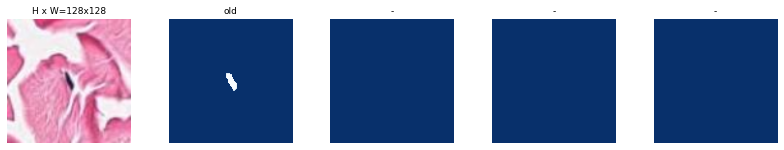

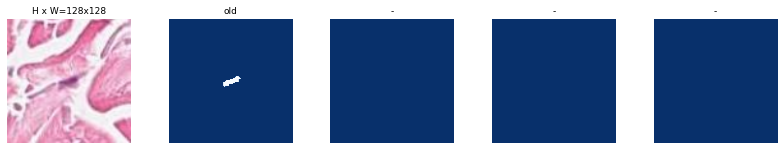

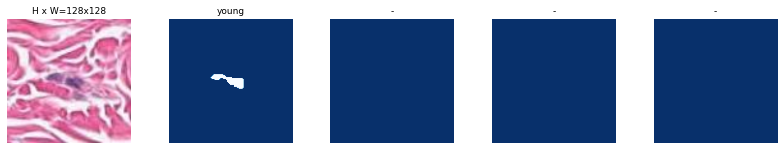

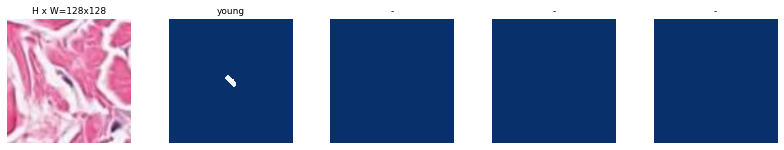

In [23]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    # print(class_ids)
    # print(np.sum(mask))
    # print(dataset_train.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

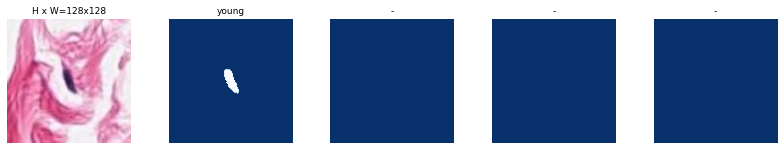

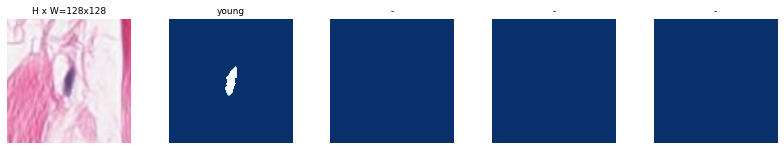

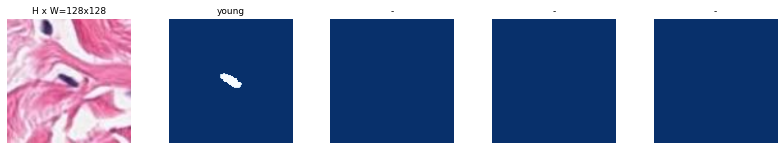

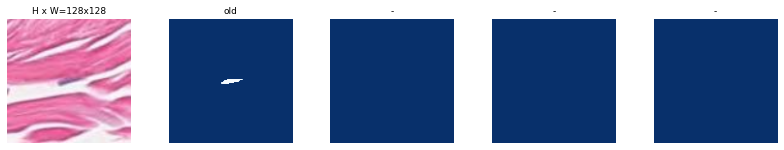

In [24]:
image_ids = np.random.choice(dataset_val.image_ids, 4)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    # print(class_ids)
    # print(np.sum(mask))
    # print(dataset_val.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

In [25]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

keras version 2.2.5
tf version 1.15.0
keras version 2.2.5
tf version 1.15.0


In [26]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

KeyboardInterrupt: 

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2,
            layers="all")

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MAX_DIM = 128
inference_config = InferenceConfig()

In [ ]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask, masksizes =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, sixth=True)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
masksizes

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

print("mAP: ", np.mean(APs))